# Product Names Clustering using Natural Language Processing and K-Means Clustering Algorithem

In this project, i will demonstrate how we can use NLP and K-means in Python to automatically cluster unlabelled product names to quickly understand what kinds of products are in a data set. This method is unsupervised (the categories are unknown and number of categories are not set) and differs from classification which is supervised and allocates product names to target labels (known categories).
For this guide I’ll be using a data set from the Australian Food Composition Database which contains data on the nutrient content of Australian foods.

The method consists of the following steps:

<ol>
    <li><b>Preprocessing</b> the text (the food names) into clean words so that we can turn it into numerical data.</li>
  <li><b>Vectorisation</b> which is the process of turning words into numerical features to prepare for machine learning.</li>
  <li>Applying<b> K-means clustering</b>, an unsupervised machine learning algorithm, to group food names with similar words together.</li>
  <li>Assessing <b>cluster quality</b> through cluster labelling and visualisation.</li>
   <li><b>Finetuning</b> steps 1–4 to improve cluster quality.</li> 
</ol>

## Python Libraries

In [1]:
#Download once if using NLTK for preprocessing
import nltk
#nltk.download('punkt')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import plotly.express as px

#Libraries for preprocessing
from gensim.parsing.preprocessing import remove_stopwords
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import webcolors

#Download once if using NLTK for preprocessing
import nltk
nltk.download('punkt')

#Libraries for vectorisation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from fuzzywuzzy import fuzz

#Libraries for clustering
from sklearn.cluster import KMeans

#Load data set
data_xls = pd.read_excel('Fooddetailsfile.xlsx', encoding='utf-8')

data_xls

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zohai\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Public Food Key,Food Profile ID,Derivation,Name,Description,Scientific Name,Sampling details,Nitrogen Factor,Fat Factor,Specific Gravity,Analysed portion,Unanalysed portion,Classification ID,Classification Name
0,F002258,10995,Borrowed,"Cardamom seed, dried, ground",Ground spice commonly used in Indian cooking a...,Elettaria cardamom,The majority of nutrient data were borrowed fr...,6.25,0.956,0.0,1,0,31302,Herbs(dried) and spices
1,F002893,11014,Borrowed,"Chilli (chili), dried, ground","Dried and ground red pepper, characterised by ...",Capsicum spp,The majority of nutrient data was borrowed USD...,6.25,0.800,0.0,1,0,31302,Herbs(dried) and spices
2,F002963,10996,Borrowed,"Cinnamon, dried, ground",Dried and ground bark or quills of Cinnamomum ...,"Cinnamomum verum, C zeylanicum or C. aromaticum",The majority of nutrient data were borrowed fr...,6.25,0.956,0.0,1,0,31302,Herbs(dried) and spices
3,F002970,10997,Borrowed,"Cloves, dried, ground","Dried and ground, unopened flower buds of Syzy...",Syzygium aromaticum,The majority of nutrient data were borrowed fr...,6.25,0.956,0.0,1,0,31302,Herbs(dried) and spices
4,F003190,10998,Borrowed,"Coriander seed, dried, ground",Dried and ground fruit or seed of Coriandrum s...,Coriandrum sativum,The majority of nutrient data were borrowed fr...,6.25,0.956,0.0,1,0,31302,Herbs(dried) and spices
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,F009774,13387,Recipe,"Zucchini, green skin, fresh, unpeeled, fried, ...","A variety of summer squash, picked when small....",Cucurbita pepo,These nutrient data were derived using a recip...,0.00,0.000,0.0,"93% (flesh, skin, seeds)","7% (stalk, ends)",24702,Squash and zucchini
1530,F009773,13388,Recipe,"Zucchini, green skin, fresh, unpeeled, boiled,...","Variety of marrow or summer squash, picked whe...",Cucurbita pepo,These nutrient data were derived using a recip...,0.00,0.000,0.0,"93% (flesh, skin, seeds)","7% (stalk, ends)",24702,Squash and zucchini
1531,F009766,13384,Analysed,"Zucchini, golden, fresh, unpeeled, raw",Variety of squash which has a yellow smooth sk...,Cucurbita pepo,The majority of nutrient data were derived fro...,6.25,0.800,0.0,"92% (flesh, skin, seeds)",8% (stalk ends),24702,Squash and zucchini
1532,F009765,13404,Recipe,"Zucchini, golden, fresh, unpeeled, fried, no a...",Variety of squash which has a yellow smooth sk...,NaN,These nutrient data were derived using a recip...,0.00,0.000,0.0,0.92,0.08,24702,Squash and zucchini


In [2]:

text1=data_xls['Name'] # make a series
print(type(text1))
print(text1.name)
print(text1)

<class 'pandas.core.series.Series'>
Name
0                            Cardamom seed, dried, ground
1                           Chilli (chili), dried, ground
2                                 Cinnamon, dried, ground
3                                   Cloves, dried, ground
4                           Coriander seed, dried, ground
                              ...                        
1529    Zucchini, green skin, fresh, unpeeled, fried, ...
1530    Zucchini, green skin, fresh, unpeeled, boiled,...
1531               Zucchini, golden, fresh, unpeeled, raw
1532    Zucchini, golden, fresh, unpeeled, fried, no a...
1533    Zucchini, golden, fresh, unpeeled, boiled, dra...
Name: Name, Length: 1534, dtype: object


## Preprocessing

The aim of the preprocessing here is to remove unnecessary words and characters so that the words in our food names are meaningful for clustering . There are many preprocessing techniques and selecting which ones to use depends on how they’ll affect the clusters. Here are the techniques I used and why.

## Removing stopwords, punctuation and numbers

Stopwords are the common words in language like ‘the’, ‘a’, ‘is’, ‘and’. Since many food names may contain such words which make the clusters to learn from them and will create confusion. Therefor, they are not really useful for clustering.
Similar case for punctuation and numbers.
We’ll remove stopwords using the Gensim library, and punctuation and numbers using the String library.

In [3]:
#Remove stopwords, punctuation and numbers
text2 = [remove_stopwords(x).translate(str.maketrans('','',string.punctuation)).translate(str.maketrans('','',string.digits))
        for x in text1]

In [4]:
print(text2[0:5])

['Cardamom seed dried ground', 'Chilli chili dried ground', 'Cinnamon dried ground', 'Cloves dried ground', 'Coriander seed dried ground']


## Stemming and making words lower case
Stemming words involves shortening them to their root forms. For example ‘apple’ and ‘apples’ both become ‘appl’ and are treated as the same word in the vectorisation stage.
Note: lemmatisation would reduce both words to the real word ‘apple’ based on context. It is more computationally expensive and wasn’t required for this exercise as I could easily tell what the stemmed words referred to.
Using the NLTK library will also make all words lower case. This is useful so that ‘Appl’ and ‘appl’ are treated as the same word in the vectorisation stage.

In [5]:
#Stem and make lower case
def stemSentence(sentence):
    porter = PorterStemmer()
    token_words = word_tokenize(sentence)
    stem_sentence = [porter.stem(word) for word in token_words]
    return ' '.join(stem_sentence)

text3 = pd.Series([stemSentence(x) for x in text2])  # get the list of each Stemm food item and convert it to series 

In [6]:
text3

0                          cardamom seed dri ground
1                           chilli chili dri ground
2                               cinnamon dri ground
3                                  clove dri ground
4                           coriand seed dri ground
                           ...                     
1529    zucchini green skin fresh unpeel fri ad fat
1530    zucchini green skin fresh unpeel boil drain
1531               zucchini golden fresh unpeel raw
1532        zucchini golden fresh unpeel fri ad fat
1533        zucchini golden fresh unpeel boil drain
Length: 1534, dtype: object

## Removing colours
Having colours in our food names will likely yield clusters of same-coloured but otherwise unrelated foods. We’ll remove colours using the Webcolors dictionary, but not the colours that are also foods (eg: ‘chocolate’ and ‘lime’).

In [9]:
#Remove colours
colors = list(webcolors.CSS3_NAMES_TO_HEX)
colors = [stemSentence(x) for x in colors if x not in ('bisque','blanchedalmond','chocolate','honeydew','lime',
                                         'olive','orange','plum','salmon','tomato','wheat')]
#print(colors)
text4 = [' '.join([x for x in string.split() if x not in colors]) for string in text3]

In [10]:
text4

['cardamom seed dri ground',
 'chilli chili dri ground',
 'cinnamon dri ground',
 'clove dri ground',
 'coriand seed dri ground',
 'cumin cummin seed dri ground',
 'curri powder',
 'fenugreek seed dri',
 'ginger dri ground',
 'mustard powder',
 'nutmeg dri ground',
 'oregano dri',
 'paprika dri powder',
 'pepper ground',
 'rosemari dri',
 'sage dri',
 'thyme dri ground',
 'turmer dri ground',
 'salt substitut potassium chlorid',
 'salt tabl iodis',
 'salt tabl noniodis',
 'stock dri powder cube',
 'taco season mix chillibas',
 'bake powder dri powder',
 'bake soda bicarbon dri powder',
 'cream tartar dri powder',
 'gelatin type',
 'gluten wheat vital wheat gluten',
 'starch potato',
 'vanilla artifici imit',
 'vanilla bean extract',
 'yeast dri powder',
 'beer high alcohol vv abov',
 'beer strength alcohol vv',
 'beer strength alcohol vv carbohydr modifi',
 'beer midstrength alcohol vv',
 'beer light alcohol vv',
 'alcohol beverag spirit approxim vv brandi gin rum vodka whiski',
 'alco

In [89]:
text_after=pd.Series(text4)
text_after.name='text_after'
total=pd.concat([text1, text_after],axis=1)
total


,Name,text_after
0,"Cardamom seed, dried, ground",cardamom seed dri ground
1,"Chilli (chili), dried, ground",chilli chili dri ground
2,"Cinnamon, dried, ground",cinnamon dri ground
3,"Cloves, dried, ground",clove dri ground
4,"Coriander seed, dried, ground",coriand seed dri ground
...,...,...
1529,"Zucchini, green skin, fresh, unpeeled, fried, ...",zucchini skin fresh unpeel fri ad fat
1530,"Zucchini, green skin, fresh, unpeeled, boiled,...",zucchini skin fresh unpeel boil drain
1531,"Zucchini, golden, fresh, unpeeled, raw",zucchini golden fresh unpeel raw
1532,"Zucchini, golden, fresh, unpeeled, fried, no a...",zucchini golden fresh unpeel fri ad fat


Some Python libraries used in the vectorisation stage have some of these techniques built-in. However, if testing multiple vectorisation models, it’s best to start with a consistent, clean text to be able to compare output.
## Vectorisation
We now want to turn our cleaned text into numerical data so that we can perform statistical analysis on it.
Just like preprocessing, there are many techniques to choose from. These are the models I tested.
## Bag of words
Bag of words (using sci-kit learn’s CountVectorizer) is a basic model that counts the occurrences of words in a document. Here, each row — one food name — is a document. The result is a matrix containing a feature for each distinct word in the text and the count of each word in a row (or vector) as its numerical values.

In [13]:
#Bag of words
vectorizer_cv = CountVectorizer(analyzer='word')
X_cv = vectorizer_cv.fit_transform(text4)
print(X_cv.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


In [100]:
matrix=pd.concat([text1,pd.DataFrame(X_cv.toarray(),columns=vectorizer_cv.get_feature_names())],axis=1)
matrix.head()

,Name,abalon,abov,acacia,ad,african,albumen,alcohol,alfalfa,allsort,...,yeast,yellowey,yellowfin,yellowtail,yoghurt,yoghurtco,yolk,young,zn,zucchini
0,"Cardamom seed, dried, ground",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Chilli (chili), dried, ground",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Cinnamon, dried, ground",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Cloves, dried, ground",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Coriander seed, dried, ground",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Here’s the matrix again, subsetted to show only the words in the first row. Note the counts for each row.


In [101]:
matrix=pd.concat([text1,pd.DataFrame(X_cv.toarray(),columns=vectorizer_cv.get_feature_names())],axis=1)
#matrix.head()

In [102]:
matrix[['Name','cardamom','seed','dri','ground']]

,Name,cardamom,seed,dri,ground
0,"Cardamom seed, dried, ground",1,1,1,1
1,"Chilli (chili), dried, ground",0,0,1,1
2,"Cinnamon, dried, ground",0,0,1,1
3,"Cloves, dried, ground",0,0,1,1
4,"Coriander seed, dried, ground",0,1,1,1
...,...,...,...,...,...
1529,"Zucchini, green skin, fresh, unpeeled, fried, ...",0,0,0,0
1530,"Zucchini, green skin, fresh, unpeeled, boiled,...",0,0,0,0
1531,"Zucchini, golden, fresh, unpeeled, raw",0,0,0,0
1532,"Zucchini, golden, fresh, unpeeled, fried, no a...",0,0,0,0


A basic count of words like this may not be enough to extract meaning. In this case, some words in a food name are more pertinent to what type of food it is. For example in ‘Broccolini, fresh, raw’, the word ‘broccolini’ is more important than ‘fresh’ or ‘raw’ for our clustering but bag of words gives all three equal weight.

## TF-IDF (word level)
TF-IDF (using sci-kit learn’s TfidfVectorizer) measures the frequency of a word in a document and compares it to the frequencies of all words in the text to assign it a weighted score of importance.
Let’s see it in action at a word level where words are considered independently of each other for meaning.

In [16]:
#TF-IDF (word level)
vectorizer_wtf = TfidfVectorizer(analyzer='word')
X_wtf = vectorizer_wtf.fit_transform(text4)

In [17]:
matrix=pd.concat([text1,pd.DataFrame(X_wtf.toarray(),columns=vectorizer_wtf.get_feature_names())],axis=1)
matrix.head()

,Name,abalon,abov,acacia,ad,african,albumen,alcohol,alfalfa,allsort,...,yeast,yellowey,yellowfin,yellowtail,yoghurt,yoghurtco,yolk,young,zn,zucchini
0,"Cardamom seed, dried, ground",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Chilli (chili), dried, ground",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Cinnamon, dried, ground",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"Cloves, dried, ground",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Coriander seed, dried, ground",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
matrix[['Name','cardamom','seed','dri','ground']]

,Name,cardamom,seed,dri,ground
0,"Cardamom seed, dried, ground",0.665248,0.469298,0.328304,0.478979
1,"Chilli (chili), dried, ground",0.000000,0.000000,0.330601,0.482331
2,"Cinnamon, dried, ground",0.000000,0.000000,0.383189,0.559054
3,"Cloves, dried, ground",0.000000,0.000000,0.371788,0.542421
4,"Coriander seed, dried, ground",0.000000,0.480406,0.336075,0.490316
...,...,...,...,...,...
1529,"Zucchini, green skin, fresh, unpeeled, fried, ...",0.000000,0.000000,0.000000,0.000000
1530,"Zucchini, green skin, fresh, unpeeled, boiled,...",0.000000,0.000000,0.000000,0.000000
1531,"Zucchini, golden, fresh, unpeeled, raw",0.000000,0.000000,0.000000,0.000000
1532,"Zucchini, golden, fresh, unpeeled, fried, no a...",0.000000,0.000000,0.000000,0.000000


Now we have different values for each word of the vector. In the first row, ‘cardamom’ has the highest score which is great!

## TF-IDF (n-gram level)
We can use TF-IDF at an n-gram level where the frequency of sequences of words is also considered.

In [19]:
#TF-IDF (n-gram level)
vectorizer_ntf = TfidfVectorizer(analyzer='word',ngram_range=(1,2))
X_ntf = vectorizer_ntf.fit_transform(text4)

In [20]:
matrix=pd.concat([text1,pd.DataFrame(X_ntf.toarray(),columns=vectorizer_ntf.get_feature_names())],axis=1)
matrix.head()

,Name,abalon,abalon lip,abov,acacia,acacia ground,ad,ad butter,ad ca,ad calcium,...,yolk hardboil,yolk raw,young,young immatur,zn,zn jackaroo,zn vitamin,zucchini,zucchini golden,zucchini skin
0,"Cardamom seed, dried, ground",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Chilli (chili), dried, ground",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Cinnamon, dried, ground",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"Cloves, dried, ground",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Coriander seed, dried, ground",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Here I used the ngram_range parameter to tell the model to consider n-grams between 1 (individual words) and 2 (sequences of 2 words or bi-grams). The first row has values against the bi-grams ‘cardamom seed’, ‘seed dried’ and ‘dried ground’, with the highest score for ‘cardamom seed’. Awesome!
I tested increasing the ngram_range upper limit to 3, 4 and 5 but 2 worked best for this data set in the clustering later. The documents (our food names) are relatively short and there weren’t many meaningful n-grams that were longer than 2 words.

## Latent Dirichlet Allocation (LDA)
LDA identifies patterns in word frequency to probabilistically estimate the topics of documents and the words used in those topics. It assumes each document is made up of several topics and similar topics use similar words. Like in bag of words, each word is considered independently of each other in the model.
LDA can be very useful for large documents, such as news articles, in uncovering its high level themes. However, it wasn’t quite right for this data set as each food name isn’t necessarily made up of multiple topics.
I tested for the optimal learning rate and number of topics to tell the model to find. Here is the result at 30 topics and the top 5 words per topic.

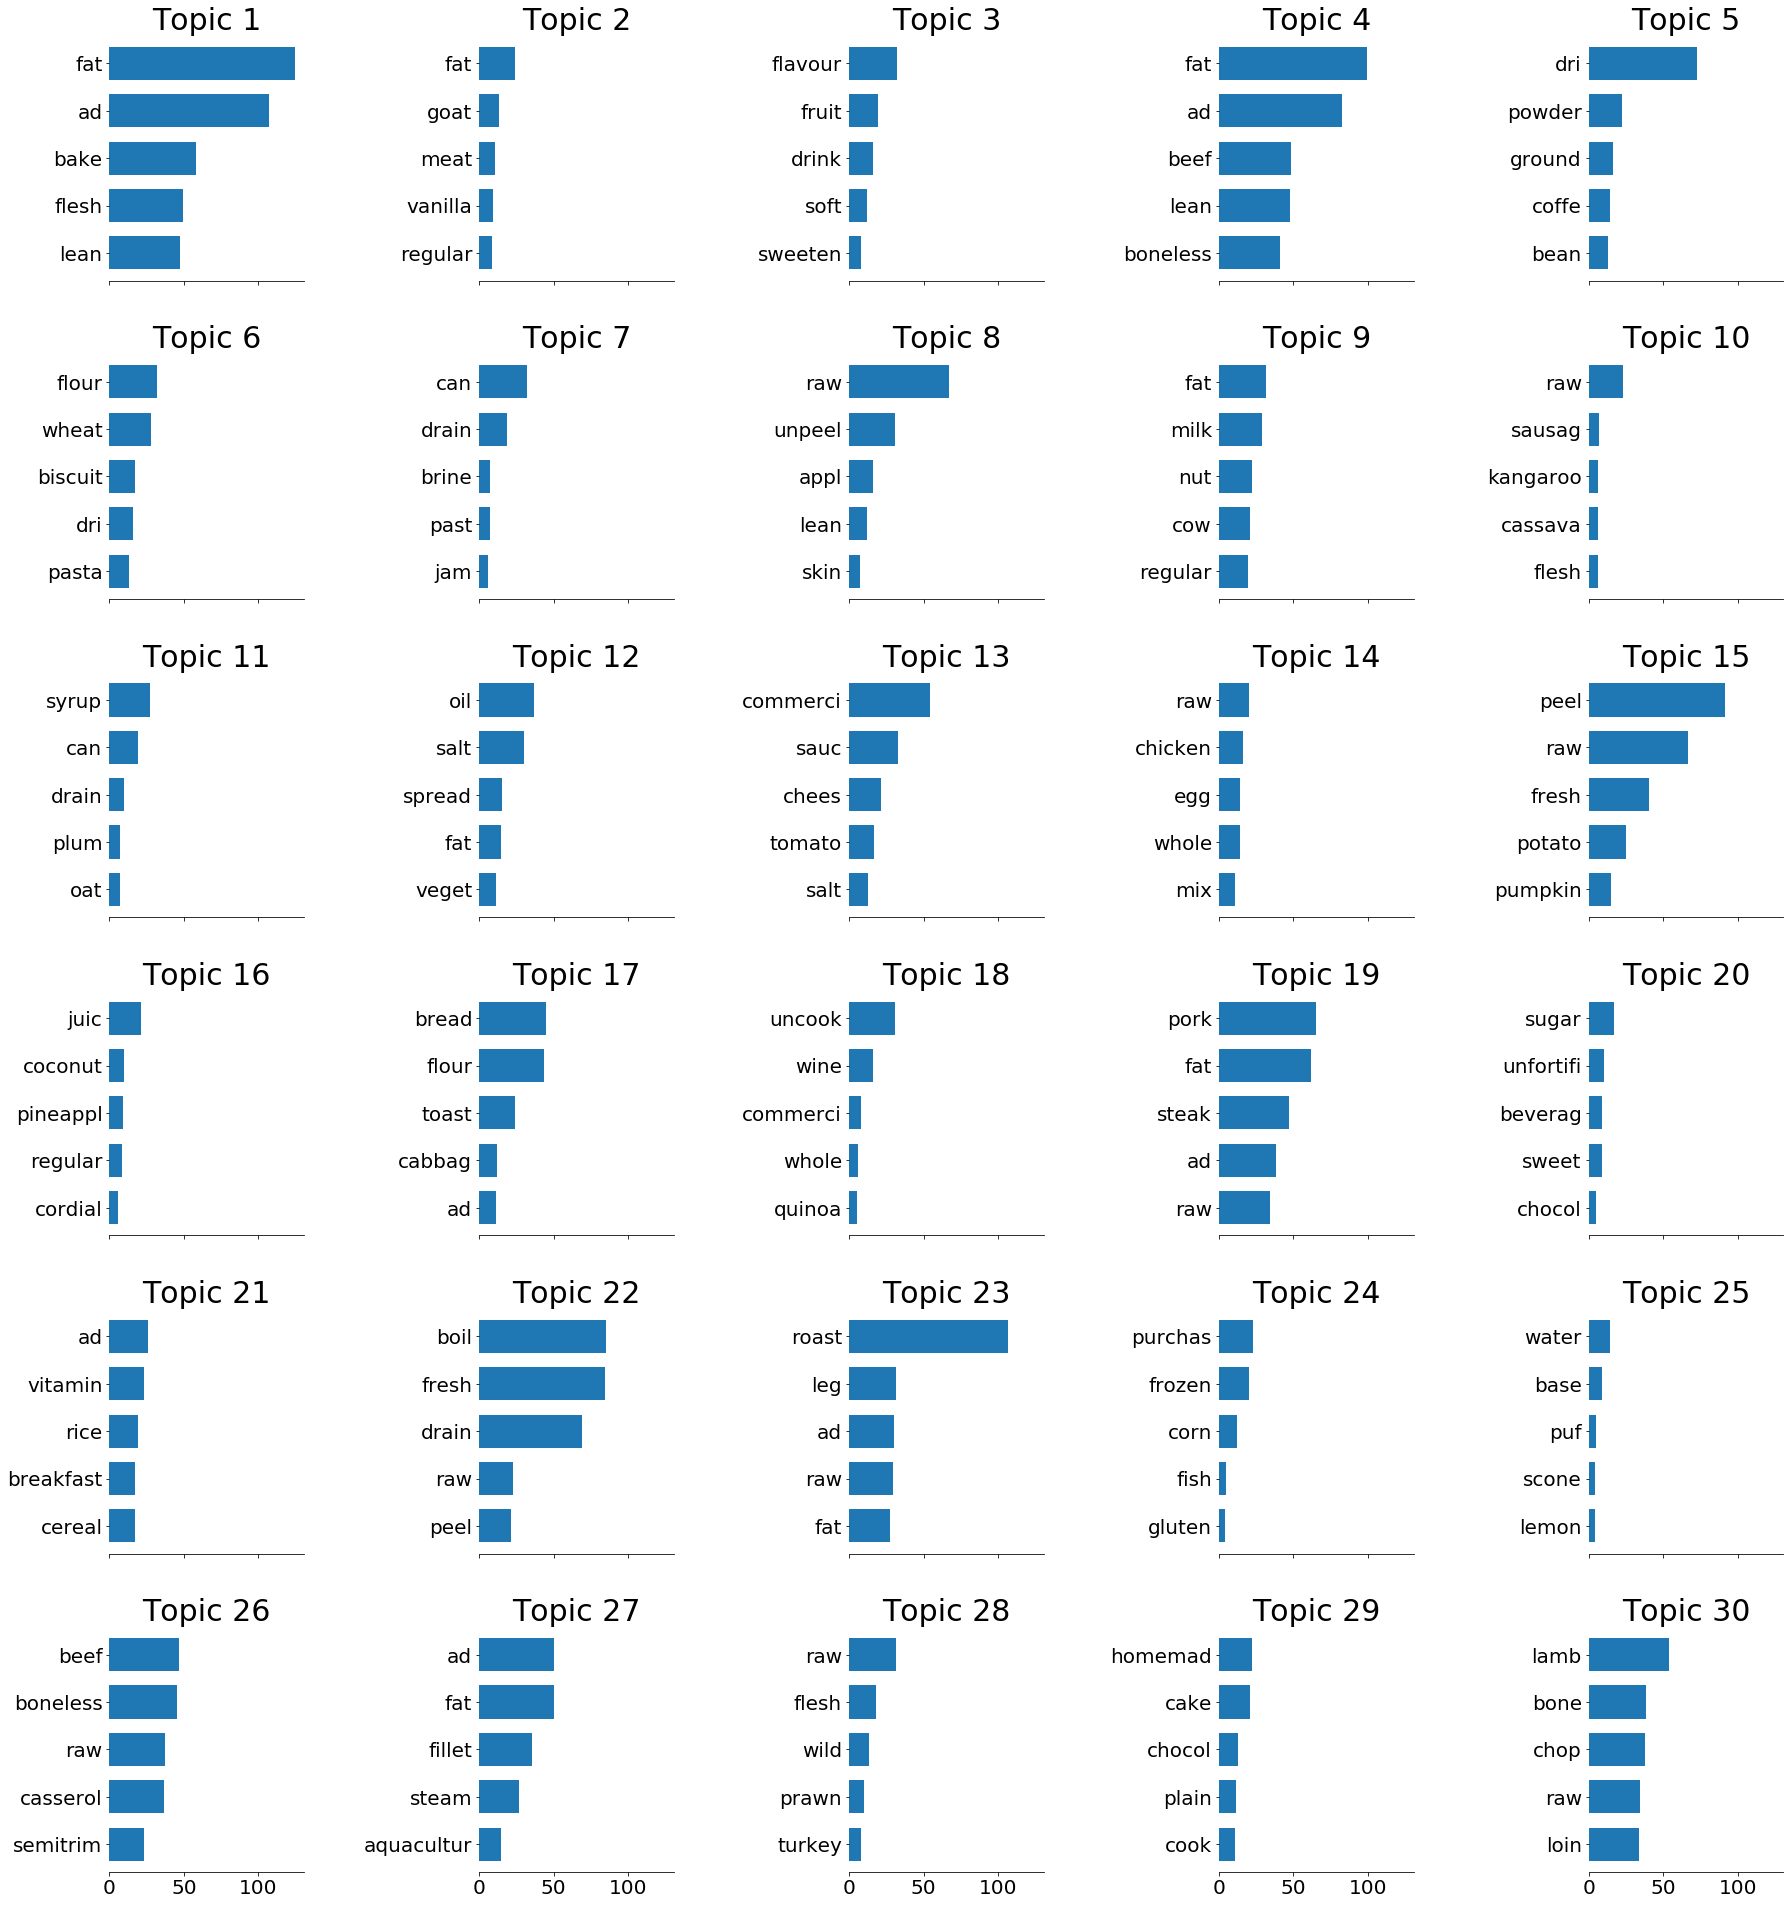

In [21]:
#LDA
lda = LatentDirichletAllocation(n_components=30, learning_decay=0.9)
X_lda = lda.fit(X_cv)

#Plot topics function. Code from: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(6, 5, figsize=(30, 30), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    
#Show topics
n_top_words = 5
feature_names = vectorizer_cv.get_feature_names()
plot_top_words(X_lda, feature_names, n_top_words, '')

## Fuzzywuzzy
Lastly, Fuzzywuzzy calculates a similarity score between two strings and is great for fuzzy (as opposed to exact) matching. This one was some outside-the-box thinking. My logic was that if food names of the same food type were worded slightly differently (eg: different kinds of apples), they would yield a high similarity score.
Here I created a matrix of each food name and its similarity score with every other food name. I ended up with 1,534 rows (one for each food name) and 1,500 columns (one for each distinct food name after preprocessing).

In [23]:
text4=pd.Series(text4)
#Fuzzywuzzy
X_fuzz = pd.crosstab([text4.index,text4],text4).apply(lambda col: [fuzz.token_sort_ratio(col.name, x) 
                                                                   for x in col.index.get_level_values(1)])


In [24]:
X_fuzz

,col_0,abalon lip aquacultur raw,abalon lip wild raw,alcohol beverag spirit approxim vv brandi gin rum vodka whiski,alcohol beverag spirit approxim vv brandi gin rum vodka whiski cook,amaranth grain whole uncook,anchovi can oil drain,appl bonza unpeel raw,appl delici unpeel raw,appl dri,appl fuji unpeel raw,...,yoghurt soy base vanilla flavour reduc fat fat,yoghurt strawberri piec flavour regular fat fat,yoghurt vanilla flavour fat,yoghurt vanilla flavour low fat less fat,zucchini golden fresh unpeel boil drain,zucchini golden fresh unpeel fri ad fat,zucchini golden fresh unpeel raw,zucchini skin fresh unpeel boil drain,zucchini skin fresh unpeel fri ad fat,zucchini skin fresh unpeel raw
row_0,row_1,,,,,,,,,,,,,,,,,,,,,
0,cardamom seed dri ground,33,42,35,33,43,36,40,43,31,41,...,26,31,31,25,38,41,32,36,36,33
1,chilli chili dri ground,33,38,31,29,28,50,32,40,32,37,...,26,29,32,29,35,32,29,33,27,30
2,cinnamon dri ground,36,42,27,26,39,50,40,39,37,36,...,25,27,30,24,34,31,27,32,25,24
3,clove dri ground,34,40,33,31,28,49,38,42,42,39,...,26,29,33,29,36,33,29,34,26,30
4,coriand seed dri ground,29,38,35,33,44,50,41,44,32,42,...,23,29,32,25,42,39,33,40,33,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,zucchini skin fresh unpeel fri ad fat,29,29,36,37,41,31,41,41,22,42,...,41,38,34,42,68,89,67,78,100,84
1530,zucchini skin fresh unpeel boil drain,29,32,34,35,38,38,41,44,22,42,...,34,29,28,34,89,71,67,100,78,78
1531,zucchini golden fresh unpeel raw,28,31,30,28,37,34,53,52,25,46,...,28,33,31,33,79,79,100,67,67,81


Admittedly this was the slowest vectorisation method as it performed in-memory calculations for a 1,534 x 1,500 Pandas Dataframe. After clustering it performed similarly to bag of words.

## K-means clustering
This is the sexy part: clustering our word matrices.
K-means clustering allocates data points into discrete groups based on their similarity or proximity to each other. We specify the number of clusters K and the algorithm iteratively assigns each observation to a cluster until each cluster’s observations are as close as possible to its mean (or centroid).

Theoretically similar food names should be clustered together because they have similar values for the same words (and n-grams).

## Optimal number of clusters
How do we know what to specify as K? We can use the elbow method to test different values for K and compare the distances of each data point from their centroids (the sum of squared errors or SSE).
To understand the types of foods in our data set, we want to balance having food names be as similar as possible in a cluster (low SSE) and having meaningful clusters of more than 1 or 2 food names each.
Let’s do this with our bag of words matrix. We know there are 851 distinct words in our food names so there can’t be more food types than that.

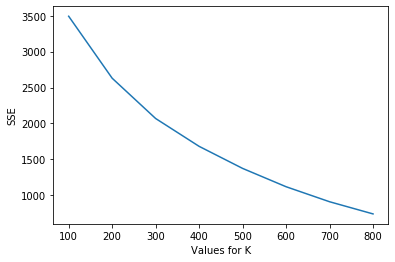

In [26]:
#Test increments of 100 clusters using elbow method
sse={}
for k in np.arange(100,900,100):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X_cv)
    sse[k] = kmeans.inertia_
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel('Values for K')
plt.ylabel('SSE')
plt.show();

The more clusters we create, the lower the SSE should be and the closer together each cluster is from its centroid. If we were to extend the graph to K=1,500 (one cluster for each distinct food name), SSE would be 0.
The elbow point looks to be at 200. The decline in SSE after this point starts to get increasingly smaller.
## Creating the clusters
Let’s start here and test K=200.

In [27]:
#Create 200 clusters
kmeans = KMeans(n_clusters=200)
kmeans.fit(X_cv)
result = pd.concat([text1,pd.DataFrame(X_cv.toarray(),columns=vectorizer_cv.get_feature_names())],axis=1)
result['cluster'] = kmeans.predict(X_cv)

In [38]:
result[['Name','cluster']]

,Name,cluster
0,"Cardamom seed, dried, ground",144
1,"Chilli (chili), dried, ground",144
2,"Cinnamon, dried, ground",144
3,"Cloves, dried, ground",144
4,"Coriander seed, dried, ground",144
...,...,...
1529,"Zucchini, green skin, fresh, unpeeled, fried, ...",189
1530,"Zucchini, green skin, fresh, unpeeled, boiled,...",25
1531,"Zucchini, golden, fresh, unpeeled, raw",5
1532,"Zucchini, golden, fresh, unpeeled, fried, no a...",189


Now each row in our bag of words matrix has been assigned to a cluster between 0 and 199. And you can see our ground spices in the first 5 rows are in the same cluster. Wahoo!
Assessing cluster quality
Creating the clusters was easy enough. Now we want to know if the clustering appropriately answers the question of what kinds of foods are in the data set. We already know that more clusters should mean a lower SSE. But how does that affect how meaningful the clusters are?
We need other measures to compare different numbers of clusters as well as the different word matrices. Note: SSE shouldn’t be used to compare different matrices as their values are inherently different. For example bag of words uses integers (0, 1, 2, etc.) to represent the occurrence of a word while TF-IDF uses a weighted score between 0 and 1.
## Cluster labels for readability
Right now our clusters are numbers between 0 and 199. Let’s give our clusters human-readable labels. We can do this automatically by retrieving the matrix column names that have a value >0 for every row in a each cluster. This way we can see the word(s) that all the food names in a cluster have in common.

In [31]:
#Label each cluster with the word(s) that all of its food names have in common
clusters = result['cluster'].unique()
labels = []
for i in range(len(clusters)):
    subset = result[result['cluster'] == clusters[i]]
    words = ' '.join([x for x in np.where(subset.all()!=0,subset.columns,None) if x and x!='Name' and x!='cluster' and len(x.split()) == 1])
    labels.append(words)
labels_table = pd.DataFrame(zip(clusters,labels),columns=['cluster','label'])
result_labelled = pd.merge(result,labels_table,on='cluster',how='left')

In [37]:
labels_table

,cluster,label
0,144,ground
1,20,
2,10,dri
3,175,dri
4,34,wheat
...,...,...
195,199,ad bake fat potato
196,0,peel potato raw
197,133,boil drain peel potato
198,138,boil drain fresh peel pumpkin


In [49]:
result_labelled.label

0                 ground
1                 ground
2                 ground
3                 ground
4                 ground
              ...       
1529    ad fat fresh fri
1530         drain fresh
1531               fresh
1532    ad fat fresh fri
1533         drain fresh
Name: label, Length: 1534, dtype: object

We can start to understand what each of the clusters represent. Note: there are clusters that don’t have any common words in its food names so they remain unlabelled.
## Cluster sizing
Now that we have cluster labels, we can look at the number of labelled clusters and their sizing.

In [47]:
pd.pivot_table(result_labelled, index=['label'], values=['Name'], aggfunc='count').sort_values(['Name'], ascending=False)

,Name
label,
,137
raw,78
ad fat,47
dri,47
fresh,41
...,...
beef hamburg independ outlet patti roll salad takeaway,1
commerci deep fill fri meat roll spring veget,1
chocol dairi dessert fat regular yoghurt,1


At K=200 with the bag of words matrix, only 96 out of 1,534 food names aren’t labelled and 8 food names are in clusters of 1. Overall 93% of food names were grouped into a clean cluster. Sounds pretty good for a first test!

## Further labelling is optional
To make it even easier to evaluate cluster quality, I grouped the clusters into high level supermarket categories (fruit & vegetables, pantry, and so on). This isn’t necessary, particularly with fewer clusters, but made it a breeze to read.
Manually categorising 1,534 food names is not fun. Manually categorising a few hundred clusters is more manageable. If you have partially labelled data, this is where a classification algorithm would come in handy.
## Visualising it all together
A common method for visualising document similarities is t-SNE. It projects vectorised data with high dimensionality to two dimensions.However, with the large number of clusters we have, t-SNE is not the best for readability. It’s hard to see the discrete clusters and their sizing. And at 200 clusters, we’re looping through colourmaps several times to colour each cluster, which makes it even harder to read.
Instead, I opted for a treemap which can neatly display our cluster labels and sizes within their respective supermarket categories. Let’s see what we get with our bag of words matrix.